## Imports

In [9]:
import optuna

# Data Set
from sklearn.datasets import fetch_california_housing

# Data Management, metrics and model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



#Plots
import matplotlib.pyplot as plt

#Other
import  numpy as np
import pandas as pd

## Data and Data Split

In [10]:
seed = 42
data = fetch_california_housing()

x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=seed)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)


# Data standardization
scaler = StandardScaler()
x_train, y_train =scaler.fit(x_train).transform(x_train), scaler.fit(y_train).transform(y_train).ravel()
x_test, y_test =  scaler.fit(x_test).transform(x_test), scaler.fit(y_test).transform(y_test).ravel()

## Metrics Calculator

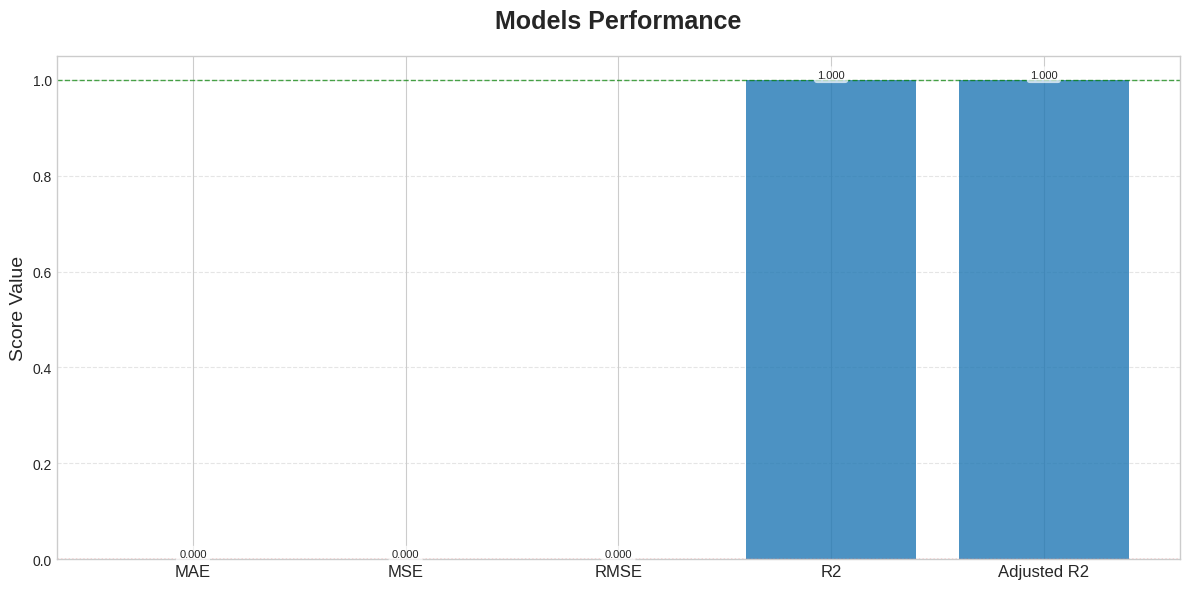

,Metric,Value
0,MAE,0.0
1,MSE,0.0
2,RMSE,0.0
3,R2,1.0
4,Adjusted R2,1.0


In [11]:
def metric(y_hat, y_true,features_shape):
    n,p = features_shape
    r2 = r2_score(y_true, y_hat)
    socres = {
        "MAE": mean_absolute_error(y_true, y_hat),
        "MSE": mean_squared_error(y_true, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_hat)),
        "R2": r2,
        "Adjusted R2":  1 - (1 - r2) * (n - 1) / (n - p - 1)
    }

    df_score = pd.DataFrame(socres.items(), columns=["Metric","Value"])

    return df_score


dummy  = metric(y_test, y_test, x_train.shape)

def plot_meterics(df_dict):

    if isinstance(df_dict, pd.DataFrame):
        df_dict = {'Model': df_dict}

    # Define the order and subset of metrics to plot
    metrics_to_plot = ["MAE", "MSE", "RMSE", "R2", "Adjusted R2"]
    metrics_order = {m: i for i, m in enumerate(metrics_to_plot)}

    # Combine and filter dataframes
    all_data = []
    for model_name, df in df_dict.items():
        # Filter for the required metrics
        filtered_df = df[df['Metric'].isin(metrics_to_plot)].copy()
        filtered_df['Model'] = model_name
        all_data.append(filtered_df)

    if not all_data:
        print("Error: No data available to plot after filtering.")
        return

    combined_df = pd.concat(all_data, ignore_index=True)

    # Sort the dataframe according to the predefined metric order
    combined_df['Order'] = combined_df['Metric'].map(metrics_order)
    combined_df.sort_values(by=['Order', 'Model'], inplace=True)

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 6))

    models = combined_df['Model'].unique()
    n_models = len(models)
    n_metrics = len(metrics_to_plot)
    bar_width = 0.8 / n_models

    x_base = np.arange(n_metrics)

    for i, model in enumerate(models):
        model_data = combined_df[combined_df['Model'] == model]
        values = model_data['Value'].values

        # Calculate position for this model's bars
        offset = (i - (n_models - 1) / 2) * bar_width
        bars = ax.bar(x_base + offset, values, bar_width, label=model, alpha=0.8)

        # Add value labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3'))


    # Customizing the plot
    ax.set_xticks(x_base)
    ax.set_xticklabels(metrics_to_plot, fontsize=12, fontweight='medium')
    ax.set_ylabel('Score Value', fontsize=14)
    ax.set_title("Models Performance", fontsize=18, fontweight='bold', pad=20)

    # Add legend if needed
    if n_models > 1 or models[0] != 'Model':
        ax.legend(title='Model', fontsize=10, title_fontsize=12, frameon=True, shadow=True)

    # Add horizontal lines for R2/Adj R2 targets for context
    ax.axhline(1.0, color='green', linestyle='--', linewidth=1.0, alpha=0.7, label='Perfect Fit (R2=1.0)')
    ax.axhline(0.0, color='red', linestyle=':', linewidth=1.0, alpha=0.7, label='Baseline Fit (R2=0.0)')

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


plot_meterics(dummy)
dummy

# Regression Models without optimalization

In [12]:
def train_and_judge(model, x_train, y_train, x_test, y_test):
    model = model
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)

    features_shape = x_train.shape
    df_train = metric(y_hat_train, y_train, features_shape)

    features_shape = x_test.shape
    df_test = metric(y_hat_test, y_test, features_shape)

    print("Training Scores")
    print(df_train)
    print()
    print("Testing Scores")
    print(df_test)

    return df_test

model_performence = {}

## KNN Regresor

In [13]:
model_performence["KNN"] = train_and_judge(KNeighborsRegressor(), x_train, y_train, x_test, y_test)

Training Scores
        Metric     Value
0          MAE  0.307235
1          MSE  0.203102
2         RMSE  0.450668
3           R2  0.796898
4  Adjusted R2  0.796800

Testing Scores
        Metric     Value
0          MAE  0.375238
1          MSE  0.306766
2         RMSE  0.553864
3           R2  0.693234
4  Adjusted R2  0.692639


## SVE

In [14]:
model_performence["SVR"] = train_and_judge(SVR(), x_train, y_train, x_test, y_test)

Training Scores
        Metric     Value
0          MAE  0.329964
1          MSE  0.248902
2         RMSE  0.498901
3           R2  0.751098
4  Adjusted R2  0.750977

Testing Scores
        Metric     Value
0          MAE  0.650450
1          MSE  0.714309
2         RMSE  0.845168
3           R2  0.285691
4  Adjusted R2  0.284304


## Random Forest

In [15]:
model_performence["RF"] = train_and_judge(RandomForestRegressor(), x_train, y_train, x_test, y_test)

Training Scores
        Metric     Value
0          MAE  0.105617
1          MSE  0.026646
2         RMSE  0.163236
3           R2  0.973354
4  Adjusted R2  0.973341

Testing Scores
        Metric     Value
0          MAE  0.484607
1          MSE  0.462323
2         RMSE  0.679944
3           R2  0.537677
4  Adjusted R2  0.536779


## Extreme Gradient Boosting Regressor

In [16]:
model_performence["XGB"] = train_and_judge(XGBRegressor(), x_train, y_train, x_test, y_test)

Training Scores
        Metric     Value
0          MAE  0.166561
1          MSE  0.055427
2         RMSE  0.235430
3           R2  0.944573
4  Adjusted R2  0.944546

Testing Scores
        Metric     Value
0          MAE  0.464387
1          MSE  0.423654
2         RMSE  0.650887
3           R2  0.576346
4  Adjusted R2  0.575523


## Model performance on test data


        Metric     Value
0          MAE  0.375238
1          MSE  0.306766
2         RMSE  0.553864
3           R2  0.693234
4  Adjusted R2  0.692639


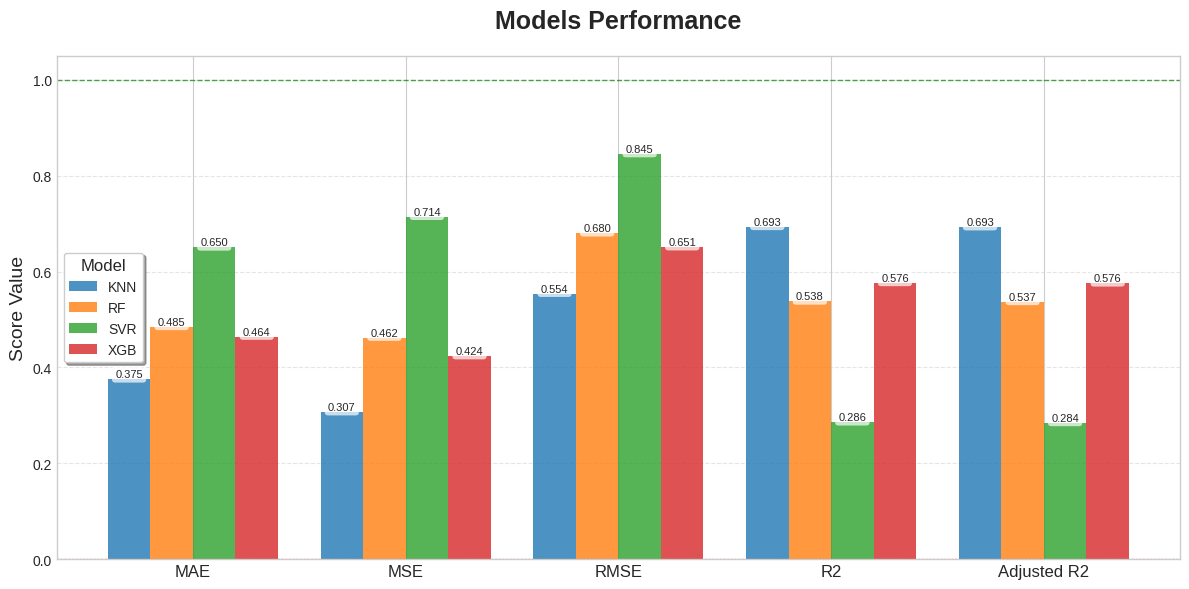

In [17]:
print(model_performence['KNN'])
plot_meterics(model_performence)


# Model with optimalization

In [18]:
def optimize_train_and_judge(model_class, objective_fn, trails=100):
    global x_train, y_train, x_test, y_test

    study = optuna.create_study(direction="maximize")
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)

    model = model_class(**study.best_params)
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    y_hat_test = model.predict(x_test)

    features_shape = x_train.shape
    df_train = metric(y_hat_train, y_train, features_shape)

    features_shape = x_test.shape
    df_test = metric(y_hat_test, y_test, features_shape)

    print("Training Scores")
    print(df_train)
    print()
    print("Testing Scores")
    print(df_test)

    return df_test

model_performence = {}

## KNN Regresor

In [19]:
def KNN_objective(trail):
    n_neighbors = trail.suggest_int("n_neighbors", 1, 80)
    weights = trail.suggest_categorical('weights', ['uniform', 'distance'])
    metric  = trail.suggest_categorical('metric', ['manhattan', 'euclidean','minkowski'])

    clf = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    clf.fit(x_train, y_train)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score


model_performence['KNN'] = optimize_train_and_judge(KNeighborsRegressor, KNN_objective)

[I 2025-11-16 19:10:14,512] A new study created in memory with name: no-name-e956198c-947c-4939-a53d-2bf7c9b57e34


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 19:10:16,564] Trial 0 finished with value: -0.2919563959617922 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 0 with value: -0.2919563959617922.
[I 2025-11-16 19:10:17,488] Trial 1 finished with value: -0.31343461701537023 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: -0.2919563959617922.
[I 2025-11-16 19:10:18,957] Trial 2 finished with value: -0.34250182278345914 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.2919563959617922.
[I 2025-11-16 19:10:19,989] Trial 3 finished with value: -0.3185793758346521 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: -0.2919563959617922.
[I 2025-11-16 19:10:20,777] Trial 4 finished with value: -0.30649903148921 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is tr

## SVR

In [20]:
def SVR_study(trial):
    C = trial.suggest_float("C", 0.01, 1)
    epsilon = trial.suggest_float("epsilon", 0.001, 0.01)
    kernel = trial.suggest_categorical('kernel', ['poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical("gamma", ['scale', 'auto'])


    clf = SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma)
    clf.fit(x_train, y_train)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

model_performence['SVR'] = optimize_train_and_judge(SVR, SVR_study, trails=5)

[I 2025-11-16 19:12:38,933] A new study created in memory with name: no-name-c095ae33-3907-48cc-b436-06f648bcb452


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-11-16 19:13:46,116] Trial 0 finished with value: -2938.0379515364066 and parameters: {'C': 0.5652216265926813, 'epsilon': 0.007490682856404726, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: -2938.0379515364066.
[I 2025-11-16 19:14:52,073] Trial 1 finished with value: -3620.342062465087 and parameters: {'C': 0.6274758658211406, 'epsilon': 0.009514843623279076, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: -2938.0379515364066.
[I 2025-11-16 19:15:34,164] Trial 2 finished with value: -0.26481447079786974 and parameters: {'C': 0.8309846600254936, 'epsilon': 0.006731534284090296, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 2 with value: -0.26481447079786974.
[I 2025-11-16 19:16:15,619] Trial 3 finished with value: -0.2682580285171109 and parameters: {'C': 0.6537776675388229, 'epsilon': 0.004286879565882501, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 2 with value: -0.26481447079786974.
[I 2025-11-16 19:17:20,814] Trial 4 finished 

## Random Forest

In [21]:
def RF_study(trail):

    n_estimators = trail.suggest_int("n_estimators", 75, 125)
    max_depth = trail.suggest_int("max_depth", 2, 10)
    min_samples_split = trail.suggest_int("min_samples_split", 2, 10)
    max_features = trail.suggest_categorical("max_features", ["sqrt", 'log2', 1.0])

    clf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, max_features=max_features ,random_state=42)
    clf.fit(x_train, y_train)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

model_performence['RF'] = optimize_train_and_judge(RandomForestRegressor, RF_study)

[I 2025-11-16 19:17:39,055] A new study created in memory with name: no-name-a5f1d1b3-6637-432f-8ca8-f34644dfbdba


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 19:18:07,703] Trial 0 finished with value: -0.24696520240010295 and parameters: {'n_estimators': 124, 'max_depth': 8, 'min_samples_split': 10, 'max_features': 1.0}. Best is trial 0 with value: -0.24696520240010295.
[I 2025-11-16 19:18:15,891] Trial 1 finished with value: -0.2277900259102294 and parameters: {'n_estimators': 98, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: -0.2277900259102294.
[I 2025-11-16 19:18:24,026] Trial 2 finished with value: -0.2602720484938249 and parameters: {'n_estimators': 123, 'max_depth': 8, 'min_samples_split': 9, 'max_features': 'sqrt'}. Best is trial 1 with value: -0.2277900259102294.
[I 2025-11-16 19:18:33,252] Trial 3 finished with value: -0.43981683545824185 and parameters: {'n_estimators': 101, 'max_depth': 3, 'min_samples_split': 6, 'max_features': 1.0}. Best is trial 1 with value: -0.2277900259102294.
[I 2025-11-16 19:18:40,169] Trial 4 finished with value: -0.28723219829815677 and para

## XGBoost


In [22]:
def XGBoost_study(trail):
    n_estimators = trail.suggest_int("n_estimators", 75, 125)
    max_depth = trail.suggest_int("max_depth", 2, 10)
    learning_rate = trail.suggest_float("learning_rate", 0.01, 0.05)
    subsample = trail.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trail.suggest_float("colsample_bytree", 0.1, 1.0)

    clf = XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree)
    clf.fit(x_train, y_train)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, x_train, y_train, cv=cv, scoring= 'neg_mean_squared_error').mean()

    return score

model_performence['XGB'] = optimize_train_and_judge(XGBRegressor, XGBoost_study)


[I 2025-11-16 19:35:22,221] A new study created in memory with name: no-name-6bcf32ed-4584-451e-88c4-fc1990975aa9


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-16 19:35:23,295] Trial 0 finished with value: -0.31939413416975615 and parameters: {'n_estimators': 110, 'max_depth': 8, 'learning_rate': 0.016011888318289046, 'subsample': 0.9345604379759396, 'colsample_bytree': 0.38216533944272635}. Best is trial 0 with value: -0.31939413416975615.
[I 2025-11-16 19:35:24,138] Trial 1 finished with value: -0.1778213299095437 and parameters: {'n_estimators': 115, 'max_depth': 8, 'learning_rate': 0.04532795229501558, 'subsample': 0.17892289574139802, 'colsample_bytree': 0.7178729977112055}. Best is trial 1 with value: -0.1778213299095437.
[I 2025-11-16 19:35:24,558] Trial 2 finished with value: -0.32493820903908566 and parameters: {'n_estimators': 96, 'max_depth': 6, 'learning_rate': 0.03379676515305641, 'subsample': 0.6112880094141534, 'colsample_bytree': 0.3561395236895998}. Best is trial 1 with value: -0.1778213299095437.
[I 2025-11-16 19:35:24,918] Trial 3 finished with value: -0.5501825430079986 and parameters: {'n_estimators': 78, 'max_

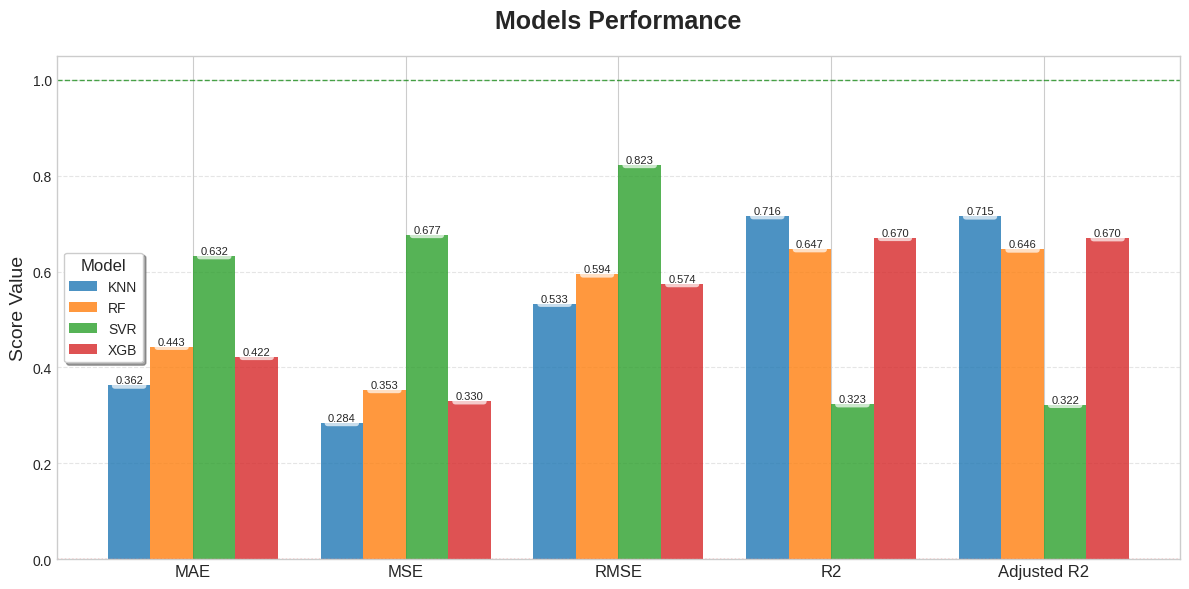

In [23]:
plot_meterics(model_performence)